# Student Name:

# Preface

In the example below, we have two classes, Environment and Agent. The Environment has 4 possible actions in all states (there are no states actually in this case but states can be easily added to the class) and regardless of the Agent's action the Environment generates a reward from normal distribution with mean 6 and variance 1. The Agent can choose one of the actions available to it and picks them at random. Then we run the experiment for 100 time steps by calling rewards_hist(100) and observe historical rewards.    

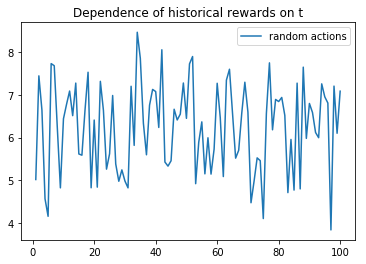

In [6]:
import random
from matplotlib import pyplot as plt 
import numpy as np

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        return random.gauss(6,1)


class Agent:
    def __init__(self):
        self.current_reward = 0.0

    def step(self, env):
        actions = env.admissible_actions()
        reward = env.get_reward(random.choice(actions))
        self.current_reward = reward
        
        
def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


from matplotlib import pyplot as plt 
import numpy as np   
T = 100
plt.plot(range(1,T+1),rewards_hist(T),label='random actions')
plt.title('Dependence of historical rewards on t')
plt.legend()
plt.show()

## Problem 1 (5 points)

Please modify the Environment so that it generates rewards with mean 4, 6, 8, and 10 for actions 1, 2, 3, and 4, respectively. Please keep unit variance in all cases. Plot your historical rewards for 1, 2,..., T, where T = 100.

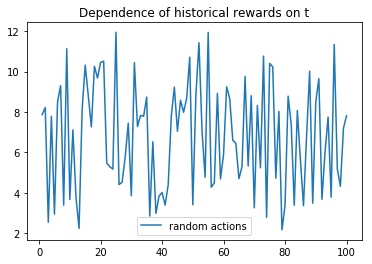

In [2]:
import random
from matplotlib import pyplot as plt 
import numpy as np
import defaultdict from collections

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        assert action in range(1, 5), "Action must be 1,2,3 and 4"
        return random.gauss(2 + action * 2,1)


class Agent:
    def __init__(self):
        self.current_reward = 0.0
        # Latest action:reward_estimate pairs:
        self.Qk_dict = defaultdict(float)
        # Latest action:reward pairs:
        self.Rk_dict = defaultdict(float)
        # action:k pairs where k is the number of times the action was executed
        self.k_dict = defaultdict(int)
    
     def estimate_reward(self, action):
        if self.k_dict[action]:
            k = self.k_dict[action]
            Qk = self.Qk_dict[action]
            Rk = self.Rk_dict[action]
            # Return Q_(k+1) by incremental update rule explained in textbook chapter 2.3
            return Qk + (Rk - Qk)/k

        else:
            # 0 reward estimate for unexecuted actions means its Q_2 = R_1
            return 0

    def step(self, env):
        #get all action
        actions = env.admissible_actions()
        # select an action
            # examine all actions - make an estimate reward for all actions Q_k+1
            # find greedy actions - max(Q_k+1)
        selected_action = random.choice(actions)
        # take an action
        reward = env.get_reward(selected_action)
        # update agent
        self.current_reward = reward 
        self.k_dict[selected_action] += 1
        self.Rk_dict[selected_action] = reward

        
def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


from matplotlib import pyplot as plt 
import numpy as np   
T = 100
plt.plot(range(1,T+1),rewards_hist(T),label='random actions')
plt.title('Dependence of historical rewards on t')
plt.legend()
plt.show()

## Problem 2 (15 points)

Modify the Agent so that it follows the $\varepsilon$-greedy selection method with $\varepsilon$ = 0.10 and the action value estimated by (2.3) of "Reinforcement Learning" by Sutton and Barto. Using this method and the Environment from Problem 1, plot observed historical rewards for 1, 2,..., T, where T = 100.

In [4]:
import random
from matplotlib import pyplot as plt 
import numpy as np
from collections import defaultdict

class Environment:
    def __init__(self, var):
        self.time = 1
        self.var = var

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        assert action in range(1, 5), "Action must be 1,2,3 and 4"
        return random.gauss(2 + action * 2,1)


class Agent:
    def __init__(self, epsilon = 0.10):
        self.epsilon = epsilon
        self.current_reward = 0.0
        # Latest action:reward_estimate pairs:
        self.Qk_dict = defaultdict(float)
        # Latest action:reward pairs:
        self.Rk_dict = defaultdict(float)
        # action:k pairs where k is the number of times the action was executed
        self.k_dict = defaultdict(int)

    def estimate_reward(self, action):
        if self.k_dict[action]:
            k = self.k_dict[action]
            Qk = self.Qk_dict[action]
            Rk = self.Rk_dict[action]
            # Return Q_(k+1) by incremental update rule explained in textbook chapter 2.3
            return Qk + (Rk - Qk)/k

        else:
            # 0 reward estimate for unexecuted actions means its Q_2 = R_1
            return 0

    def divide_greedy_actions(self, action_reward_est_dict):
        greedy_actions = []
        non_greedy_actions = []
        best_Q = -float('inf')
        for action, current_Q in action_reward_est_dict.items():
            if current_Q > best_Q:
                for previously_greedy_action in greedy_actions:
                    non_greedy_actions.append(previously_greedy_action)
                greedy_actions = [action]
                best_Q = current_Q
            elif current_Q == best_Q:
                greedy_actions.append(action)
            else:
                non_greedy_actions.append(action)

        return greedy_actions, non_greedy_actions

    def step(self, env):
        
        all_actions = env.admissible_actions()
        all_rewards = {}
        
        for action in all_actions:
            reward = self.estimate_reward(action)
            all_rewards[action] = reward
        
        # Estimate reward for all possible actions
        action_reward_est_dict = {
            action:self.estimate_reward(action) for action in env.admissible_actions()
        }
        # Divide greedy and non-greedy actions
        greedy_actions, non_greedy_actions = self.divide_greedy_actions(action_reward_est_dict)

        # choose greediness using epsilon, then selection an action
        if non_greedy_actions:
            selected_action = random.choice(
                np.random.choice(
                    [greedy_actions, non_greedy_actions],
                    p = [1 - self.epsilon, self.epsilon]
                )
            )
        else: # If no non-greedy options exist, all actions are greedy
            selected_action = random.choice(greedy_actions)

        # update new reward
        reward = env.get_reward(selected_action)
        self.current_reward = reward
        # update k, R_k and Q_k
        self.Qk_dict[selected_action] = action_reward_est_dict[selected_action]
        self.Rk_dict[selected_action] = self.current_reward
        self.k_dict[selected_action] += 1


def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


from matplotlib import pyplot as plt 
import numpy as np   
T = 100
plt.plot(range(1,T+1),rewards_hist(T),label='Ɛ = 0.1')
plt.title('Dependence of historical rewards on t')
plt.legend()
plt.show()

TypeError: __init__() missing 1 required positional argument: 'var'

## Problem 3 (5 points)

Run the algorithm obtained in Problem 2 for 200 times (i.e. for 200 epochs) for T = 1000, and compute the observed average reward for each time t. Plot the average reward from those 200 epochs for 1, 2,..., T. Please notice that T = 1000 this time.

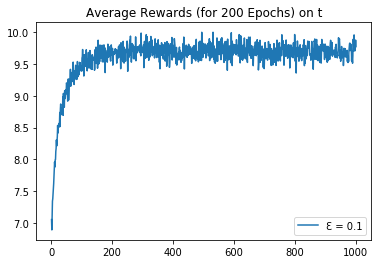

In [3]:
import random
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        assert action in range(1, 5), "Action must be 1,2,3 and 4"
        return random.gauss(2 + action * 2,1)


class Agent:
    def __init__(self, epsilon = 0.10):
        self.epsilon = epsilon
        self.current_reward = 0.0
        # Latest action:reward_estimate pairs:
        self.Qk_dict = defaultdict(float)
        # Latest action:reward pairs:
        self.Rk_dict = defaultdict(float)
        # action:k pairs where k is the number of times the action was executed
        self.k_dict = defaultdict(int)

    def estimate_reward(self, action):
        if self.k_dict[action]:
            k = self.k_dict[action]
            Qk = self.Qk_dict[action]
            Rk = self.Rk_dict[action]
            # Return Q_(k+1) by incremental update rule explained in textbook chapter 2.3
            return Qk + (Rk - Qk)/k

        else:
            # 0 reward estimate for unexecuted actions means its Q_2 = R_1
            return 0

    def divide_greedy_actions(self, action_reward_est_dict):
        greedy_actions = []
        non_greedy_actions = []
        best_Q = -float('inf')
        for action, current_Q in action_reward_est_dict.items():
            if current_Q > best_Q:
                for previously_greedy_action in greedy_actions:
                    non_greedy_actions.append(previously_greedy_action)
                greedy_actions = [action]
                best_Q = current_Q
            elif current_Q == best_Q:
                greedy_actions.append(action)
            else:
                non_greedy_actions.append(action)

        return greedy_actions, non_greedy_actions

    def step(self, env):
        # Estimate reward for all possible actions
        action_reward_est_dict = {
            action:self.estimate_reward(action) for action in env.admissible_actions()
        }
        # Divide greedy and non-greedy actions
        greedy_actions, non_greedy_actions = self.divide_greedy_actions(action_reward_est_dict)

        # choose greediness using epsilon, then selection an action
        if non_greedy_actions:
            non_greedy_portion = len(non_greedy_actions)/(len(non_greedy_actions) + len(greedy_actions))
            selected_action = random.choice(
                np.random.choice(
                    [greedy_actions, non_greedy_actions],
                    p = [1 - self.epsilon*non_greedy_portion, self.epsilon * non_greedy_portion]
                )
            )
        else: # If no non-greedy options exist, all actions are greedy
            selected_action = random.choice(greedy_actions)

        # update new reward
        self.current_reward = env.get_reward(selected_action)
        # update k, R_k and Q_k
        self.Qk_dict[selected_action] = action_reward_est_dict[selected_action]
        self.Rk_dict[selected_action] = self.current_reward
        self.k_dict[selected_action] += 1


def average_rewards_hist(T = 10, eps = 2):
    # initiate a (eps x t) matrix
    rewards = np.empty([eps, T])

    for ep in range(eps):
        env = Environment()
        agent = Agent()

        t = 0
        while env.time <= T:
            agent.step(env)
            rewards[ep][t] = agent.current_reward
            t += 1
    return np.mean(rewards, axis=0) # average over column

from matplotlib import pyplot as plt
import numpy as np   
T = 1000
eps = 200
plt.plot(range(1,T+1), average_rewards_hist(T, eps), label= 'Ɛ ≤ 0.1')
plt.title('Average Rewards (for {} Epochs) on t'.format(eps))
plt.legend()
plt.show()

In [2]:
class Agent:
    def __init__(self):
        self.current_reward = 0.0

    def step(self, env):
        actions = env.admissible_actions()
        reward = env.get_reward(random.choice(actions))
        self.current_reward = reward    

Agent().step(env)